In [1]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

from emu_filter.state_model import predict_states
from emu_filter.importance import truncnorm_importance
from emu_filter.outputs import get_counts_from_particles, plot_particle_results, get_links_from_pedigree, plot_links

In [55]:
# Inputs
contact_rate = 2.5
recovery_rate = 0.1
total_pop = 1000
inf_init = 4
n_particles = 10
observations = [0, 15, 40, 65, 124, 204, 252, 210]
target_sd = 50.0
volatility = 0.2

In [56]:
# Initialise particles
particles = np.zeros([len(observations) + 1, 4, n_particles], dtype=int)
particles[0, 0, :] = total_pop - inf_init  # Susceptible
particles[0, 1, :] = inf_init  # Infectious
particles[0, 3, :] = contact_rate  # Random process
prop_particles = np.copy(particles)
pedigree = np.zeros([len(observations), n_particles], dtype=int)


resamp_particles = particles[0, :, :]

# Main loop
for o, obs in enumerate(observations):
    
    # Prediction
    # proposed_particles = predict_states(particles[o, :, :], contact_rate, recovery_rate, total_pop)
    proposed_particles = np.empty_like(particles[o, :, :])
    suscept, infect, recovered, process = resamp_particles[0, :], resamp_particles[1, :], resamp_particles[2, :], resamp_particles[3, :]
    new_contact_rates = np.exp(np.random.normal(np.log(process), volatility, n_particles))
    new_infections = new_contact_rates * suscept * infect / total_pop
    new_recoveries = recovery_rate * infect

    proposed_particles[0, :] = suscept - new_infections
    proposed_particles[1, :] = infect + new_infections - new_recoveries
    proposed_particles[2, :] = recovered + new_recoveries
    proposed_particles[3, :] = new_contact_rates
    
    prop_particles[o + 1, :] = proposed_particles

    # Importance
    weights = truncnorm_importance(proposed_particles[1, :], obs, target_sd)
    norm_weights = weights / sum(weights)

    # Resampling
    indices = np.random.choice(n_particles, size=n_particles, p=norm_weights)
    pedigree[o, :] = indices
    resamp_particles = proposed_particles[:, indices]
    
    # Update
    particles[o + 1, :, :] = resamp_particles

/var/folders/h7/clpfbqrd2ddc77wnbm6pqyq80000gn/T/ipykernel_49681/1875239488.py:19: RuntimeWarning: divide by zero encountered in log
  new_contact_rates = np.exp(np.random.normal(np.log(process), volatility, n_particles))


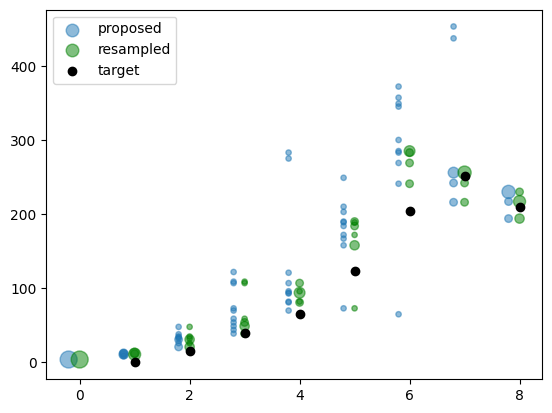

In [57]:
plot_particle_results(prop_particles, particles, observations)

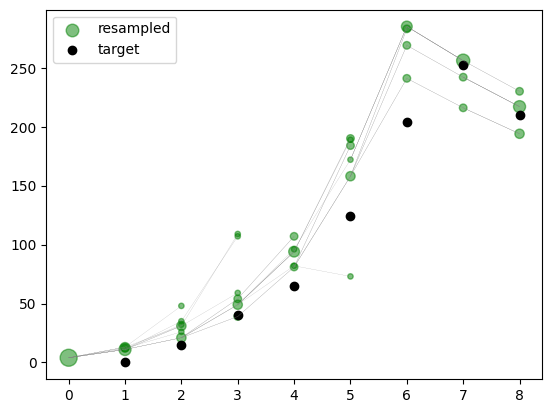

In [58]:
links = get_links_from_pedigree(particles, pedigree, observations)
plot_links(particles, links, observations)